# Genetic Algorithm Assignment
30% of the overall grade for this module

Marks indciated in sections below are based on percentage of marks allocated for this module

In this assignment you must choose a problem, and attempt to use the Genetic Alogrithm that we developed in class to solve this problem.





## The Problem         **(~30%)**

*   Description of the problem





---

The problem adressed by this assignment is image generation. Given a target image, is it possible to generate a copy of that image using random noise as the source via the genetic algorithm. This task does not require a particularity complex cost function, as cost is being calculated using the mean squared error each pixel is essentially being assessed individually against its correspdoning target pixel. For this task we also don't have to worry about arrangement problems like would be the case when trying to solve problems such as sudoku, where the cost of a chromosome is influenced by the position of genes in relation to each other, not just on their individual value.

---



*   Discussion of the suitablity of Genetic Algorithms


---

From an intial look the genetic algorithm is suitable for image generation from the perspective that it is possible, each generation should in theory adjust the channel values of pixels and through mutation and crossover have them trend towards the target solution over time. However, as will be discussed later it may not be the ideal algorithm to use due to how computatinally expensive generation can become at higher resolutions.

---



*   Complexity of the problem  (Overall marks allocated based on ..)

# The problem and the cost function   **(~20%)**

In [1]:
#imports
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
#This cell is for importing an image to use as the target instead of random noise
file_path = './testimg3.png'

#Importing and converting the image to a numpy array so that we can then chop off the alpha channel if it exists
with Image.open(file_path) as img:
    img_array = np.array(img)
        
new_img = Image.fromarray(img_array[:, :, :3])
new_img.show()
target_image = new_img

In [19]:
#This cost function takes in the target image and the individual and returns the mean squared error between the two images
#Casting as 64 bit integers to avoid overflow errors, ran into issues percision issues with 8 bit integers
def cost_function(individual, target_image):
    return np.mean((individual.astype(np.uint64) - np.array(target_image).astype(np.uint64)) ** 2)
    
#Used for generating new random chromosomes   
def create_random_image(width, height):
    return np.random.randint(0, 255, (width, height, 3), dtype=np.uint8)


#Image dimensions are set by the problem, with and height relate to pixel count, number of genes is the number of pixels, which is the x and y dimensions multiplied together.
class problem:
    def __init__(self):
        self.width = 8
        self.height = 8
        self.number_of_genes = self.width * self.height
        self.cost_function = cost_function


# The Individual **(~30%)**


*   Chromosone
*   Crossover
*   Mutation



## Discussion and justification on the approaches taken for the above

---

Chromosome: 
I am using a 3D array as my chromosome for this problem. An array of rows, each containing an array of pixels within them. Each pixel contains three elements which represent the red, green, and blue channels of a pixel with values in a range from 0 to 255. This format is easy to work with using packages like numpy, and while in theory it would be possible to use a different repsentation like a 1D linear array, that would require a lot of additional logic to be written to interpret and manipulate. 

Crossover: 
I have chosen to use single point crossover for this task, my rationale being that if two parent chromosomes are of high value (having a low cost), using single point crossover will encourage improving trends in the colour of a pixel.

Mutation: 
For my mutation I am interating through each pixel in the array, and if a randomly generated value falls below the defined mutation rate, that pixel is mutated. During this mutation each the value of that channel is set to a value between its current value minus the current mutation range, and its current value plus the current mutation range. As will be seen later in the run_genetic function, the mutation rate and range is adjust during runtime based on the number of generations processed. 

---



In [4]:
#Helper function used during mutation to ensure that the pixel values are within the range 0 to 255
def clamp(value, min_value, max_value):
    return max(min_value, min(value, max_value))

class individual:
    chromosome = None
    cost = 9999999
    number_of_genes = None

    def __init__(self, prob):
        self.chromosome = create_random_image(prob.width, prob.height)
        self.number_of_genes = prob.number_of_genes
        self.cost = prob.cost_function(self.chromosome, target_image)
        
    def mutate(self, mutation_rate, mutation_range):
        for i in range(self.number_of_genes):
            if np.random.uniform() < mutation_rate:
                row_to_mutate = np.random.randint(0, len(self.chromosome))
                pixel_to_mutate = np.random.randint(0, len(self.chromosome[row_to_mutate]))
                pixel = self.chromosome[row_to_mutate][pixel_to_mutate]

                # Generate mutation for each color channel and clamp the values
                r_mutation = clamp(np.random.uniform(pixel[0] - mutation_range, pixel[0] + mutation_range), 0, 255)
                g_mutation = clamp(np.random.uniform(pixel[1] - mutation_range, pixel[1] + mutation_range), 0, 255)
                b_mutation = clamp(np.random.uniform(pixel[2] - mutation_range, pixel[2] + mutation_range), 0, 255)

                self.chromosome[row_to_mutate][pixel_to_mutate] = [r_mutation, g_mutation, b_mutation]
            
 
    def crossover(self,parent2):
        crossover_point = np.random.randint(0, len(self.chromosome))
       
        child1 = deepcopy(self)
        child1.chromosome[crossover_point:] = parent2.chromosome[crossover_point:]

        child2 = deepcopy(parent2)
        child2.chromosome[crossover_point:] = self.chromosome[crossover_point:]

        return child1, child2
                

## Running the algorithm  **(~10%)**

*   Parameter choices
*   Modifications (if any) to run_genetic
*   Rationale for the above



---

Parameters: Setting the population to 1000, and number of generations to 600 successfully generated an image that was clearly recognizeable as the target image. Gene mutate rate and ranges are intially set to 1 and 255 respectively, which will be changed dynamically as the number of generations processed grows.

Modifications: The main modification made to run_genetic was altering mutation rate and ranges during runtime. I do this by multiplying the gene mutation by .5, .2, and .1 at 5% of generations, 30% of generations, and 80% of generations respectively.

Rationale: During early generations I am encouring high levels of mutation in order to expose the cost function to a large number of different pixel combinations. As the number of generations processed grows I decrease both the mutation rate and range to allow for pixels trending in the right direction to be refined on a more fine-grained level and avoid large swings in the "wrong" direction.


---



In [17]:
#  Parameter class here
class parameters:
  def __init__(self):
    self.population  = 1000
    self.number_of_generations = 600
    self.child_rate_per_generation = 1
    self.gene_mutate_rate = 1
    self.gene_mutate_range = 255
    #target_image can be used to set the target as an image you upload yourself
    #using create_random_image will set the target as random noise
    #self.target = target_image
    self.target = create_random_image(8,8)

In [14]:
def choose_indices_from(number_in_list):
  index_1 = np.random.randint(number_in_list)
  index_2 = np.random.randint(number_in_list)
  if index_1 == index_2:
    return choose_indices_from(number_in_list)
  return index_1,index_2

def run_genetic(prob, params):
    cost_function = prob.cost_function
    gene_mutation_rate = params.gene_mutate_rate
    number_in_population = params.population
    max_number_of_generations = params.number_of_generations
    number_of_children_per_generation = params.child_rate_per_generation * number_in_population
    gene_mutate_range = params.gene_mutate_range
    target = params.target
    population = []
    
    best_solution = individual(prob)
    best_solution.cost = np.float64('inf')
    
    for i in range(number_in_population):
        new_individual = individual(prob)
        population.append(new_individual)

        if new_individual.cost < best_solution.cost:
            best_solution = deepcopy(new_individual)


    modified_gene_mutate_rate = gene_mutation_rate
    
    for _iteration in range(max_number_of_generations):
        
        if _iteration > max_number_of_generations * 0.8:
            modified_gene_mutate_rate = 0.3
            gene_mutate_range = 255 * 0.1
        elif _iteration > max_number_of_generations * 0.3:
            modified_gene_mutate_rate = 0.5
            gene_mutate_range = 255 * 0.2
        elif _iteration > max_number_of_generations * 0.15:
            modified_gene_mutate_rate = 0.5
            gene_mutate_range = 255 * 0.5
        elif _iteration > max_number_of_generations * 0.05:
            modified_gene_mutate_rate = 0.8
            gene_mutate_range = 255 * 0.5
           
    
            
        children = []
        while len(children) < number_of_children_per_generation:
            
            parent1_index , parent2_index = choose_indices_from(len(population))
            parent1 = population[parent1_index]
            parent2 = population[parent2_index]

            child1, child2 = parent1.crossover(parent2)
            child1.mutate(modified_gene_mutate_rate, gene_mutate_range)
            child1.cost = cost_function(child1.chromosome, target)
            child2.mutate(modified_gene_mutate_rate, gene_mutate_range)
            child2.cost = cost_function(child2.chromosome, target)

            children.append(child1)
            children.append(child2)


        population += children

        population = sorted(population, key = lambda x:x.cost)

        population = population[:number_in_population]

        if population[0].cost < best_solution.cost:
            best_solution = deepcopy(population[0])


        print("Best Solution for iteration " + str(_iteration) + " has cost of " + str (best_solution.cost) + " " + str(gene_mutate_range))
        

    return best_solution

In [15]:
#This is a run using an uploaded image as the target
params = parameters()
p1 = problem()
b1 = run_genetic(p1, params)

Best Solution for iteration 0 has cost of 17233.75 255
Best Solution for iteration 1 has cost of 17233.75 255
Best Solution for iteration 2 has cost of 17233.75 255
Best Solution for iteration 3 has cost of 17233.75 255
Best Solution for iteration 4 has cost of 17233.75 255
Best Solution for iteration 5 has cost of 17233.75 255
Best Solution for iteration 6 has cost of 17233.75 255
Best Solution for iteration 7 has cost of 17233.75 255
Best Solution for iteration 8 has cost of 17233.75 255
Best Solution for iteration 9 has cost of 17233.75 255
Best Solution for iteration 10 has cost of 17233.75 255
Best Solution for iteration 11 has cost of 17233.75 255
Best Solution for iteration 12 has cost of 17233.75 255
Best Solution for iteration 13 has cost of 17233.75 255
Best Solution for iteration 14 has cost of 17233.75 255
Best Solution for iteration 15 has cost of 17233.75 255
Best Solution for iteration 16 has cost of 17233.75 255
Best Solution for iteration 17 has cost of 17233.75 255
Be

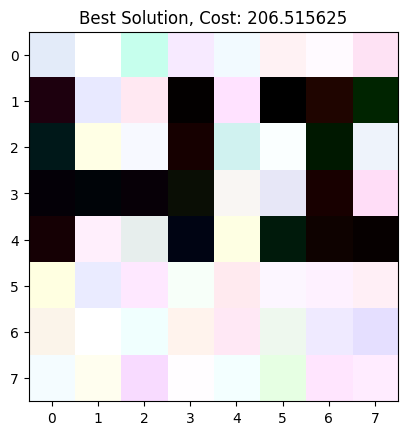

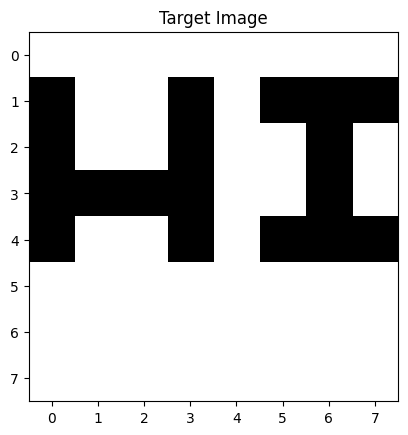

In [16]:
plt.imshow(b1.chromosome)
plt.title(f"Best Solution, Cost: {b1.cost}")
plt.show()


plt.imshow(target_image)
plt.title("Target Image")
plt.show()

In [18]:
#This is a run using a random noise image as the target
p2 = problem()
params2 = parameters()
params2.number_of_generations = 600
params2.population = 1000
b2 = run_genetic(p2, params2)

Best Solution for iteration 0 has cost of 10437.046875 255
Best Solution for iteration 1 has cost of 10437.046875 255
Best Solution for iteration 2 has cost of 10437.046875 255
Best Solution for iteration 3 has cost of 10437.046875 255
Best Solution for iteration 4 has cost of 10437.046875 255
Best Solution for iteration 5 has cost of 10437.046875 255
Best Solution for iteration 6 has cost of 10437.046875 255
Best Solution for iteration 7 has cost of 10437.046875 255
Best Solution for iteration 8 has cost of 10437.046875 255
Best Solution for iteration 9 has cost of 10437.046875 255
Best Solution for iteration 10 has cost of 10437.046875 255
Best Solution for iteration 11 has cost of 10437.046875 255
Best Solution for iteration 12 has cost of 10437.046875 255
Best Solution for iteration 13 has cost of 10437.046875 255
Best Solution for iteration 14 has cost of 10437.046875 255
Best Solution for iteration 15 has cost of 10437.046875 255
Best Solution for iteration 16 has cost of 10437.0

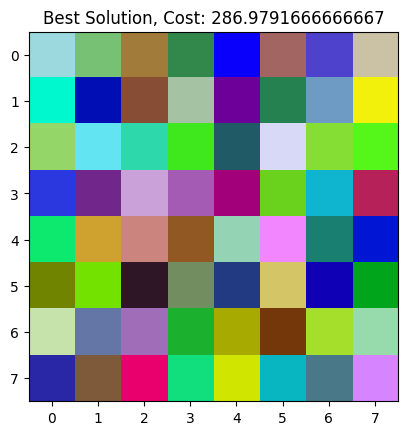

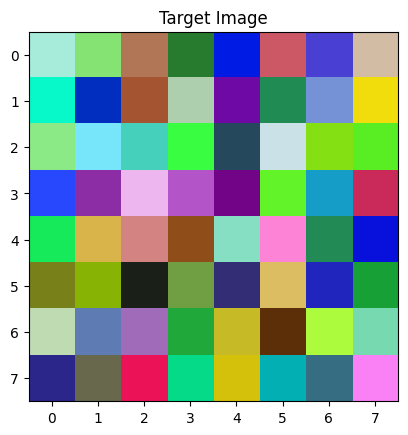

In [20]:
#Results of the run using random noise as the target
plt.imshow(b2.chromosome)
plt.title(f"Best Solution, Cost: {b2.cost}")
plt.show()

plt.imshow(params2.target)
plt.title("Target Image")
plt.show()

## Results and conclusions    **(~10%)**

---

Results: It was possible to generate images which were recognizably similar to the inputted target images despite having costs that did not reach 0. 

Conlusions: While the genetic algorithm proved effective at generating images it was computationally expensive, 600 generations taking about 11 minutes to run on my machine when using an 8x8 pixel uploaded image as the target. This approach would simply not scale without some serious optimization when attempting to generate high resolution images, for example a 1080p image consists of over 2 million pixels, 32,000 times more than used in this assignments demonstrations. Writing the cost, mutation, and crossover functions for this task was less complex than I had originally anticipated which I believe is down to the lack of relationships between genes within the chromosome. The cost of the chromosome is not affected by pixels arrangement relative to each other, only arrangement relative to the pixels of the target image.

---

